In [68]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import TargetEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, confusion_matrix, classification_report,roc_curve, accuracy_score, roc_auc_score, precision_recall_curve
from imblearn.over_sampling import SMOTE, SMOTENC
import numpy as np


**Data dictionary**:

- loan_amnt : The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
- term : The number of payments on the loan. Values are in months and can be either 36 or 60.
- int_rate : Interest Rate on the loan
- installment : The monthly payment owed by the borrower if the loan originates.
- grade : LoanTap assigned loan grade
- sub_grade : LoanTap assigned loan subgrade
- emp_title :The job title supplied by the Borrower when applying for the loan.*
- emp_length : Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
- home_ownership : The home ownership status provided by the borrower during registration or obtained from the credit report.
- annual_inc : The self-reported annual income provided by the borrower during registration.
- verification_status : Indicates if income was verified by LoanTap, not verified, or if the income source was verified
- issue_d : The month which the loan was funded
- loan_status : Current status of the loan - Target Variable
- purpose : A category provided by the borrower for the loan request.
- title : The loan title provided by the borrower
- dti : A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LoanTap loan, divided by the borrower’s self-reported monthly income.
- earliest_cr_line :The month the borrower's earliest reported credit line was opened
- open_acc : The number of open credit lines in the borrower's credit file.
- pub_rec : Number of derogatory public records
- revol_bal : Total credit revolving balance
- revol_util : Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
- total_acc : The total number of credit lines currently in the borrower's credit file
- initial_list_status : The initial listing status of the loan. Possible values are – W, F
- application_type : Indicates whether the loan is an individual application or a joint application with two co-borrowers
- mort_acc : Number of mortgage accounts.
- pub_rec_bankruptcies : Number of public record bankruptcies
- Address: Address of the individual

**Context**:

LoanTap is an online platform committed to delivering customized loan products to millennials. They innovate in an otherwise dull loan segment, to deliver instant, flexible loans on consumer friendly terms to salaried professionals and businessmen.

The data science team at LoanTap is building an underwriting layer to determine the creditworthiness of MSMEs as well as individuals.

LoanTap deploys formal credit to salaried individuals and businesses 4 main financial instruments:

Personal Loan
EMI Free Loan
Personal Overdraft
Advance Salary Loan
This case study will focus on the underwriting process behind Personal Loan only

**Problem Statement**:

Given a set of attributes for an Individual, determine if a credit line should be extended to them. If so, what should the repayment terms be in business recommendations?

## EDA

In [169]:
df = pd.read_csv("/Users/ajmal.m/Downloads/logistic_regression.txt")

In [170]:
df.shape

(396030, 27)

In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

In [172]:
(df.isna().sum()/len(df))*100

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
installment             0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.789208
emp_length              4.621115
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.443148
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.069692
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                9.543469
pub_rec_bankruptcies    0.135091
address                 0.000000
dtype: float64

- There are null values in the data

In [2033]:
### Feature Engineering and data cleaning

In [173]:
df['issue_d'] = pd.to_datetime(df['issue_d'])
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])
df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].apply({lambda x: 1 if x>=1 else 0})
df['pub_rec'] = df['pub_rec'].apply({lambda x: 1 if x>=1 else 0})
df['mort_acc'] = df['mort_acc'].apply({lambda x: 1 if x>=1 else 0})
df['term'] = df['term'].map({' 36 months':36, ' 60 months':60})
df['title']=df.title.str.lower()
df['loan_status'] = df['loan_status'].map({'Charged Off': 1, 'Fully Paid': 0})
df['zip_code'] = df.address.apply(lambda x: x[-5:])
df['emp_length'] = df['emp_length'].map({'10+ years':10, '4 years':4, '< 1 year':1, '6 years':6, '9 years':9,
       '2 years':2, '3 years':3, '8 years':8, '7 years':7, '5 years':5, '1 year':1})
list_status = {'w': 0, 'f': 1}
df['initial_list_status'] = df.initial_list_status.map(list_status)

In [174]:
df['emp_title'].nunique(), df['emp_title'].nunique()/len(df)

(173105, 0.43710072469257377)

<Axes: >

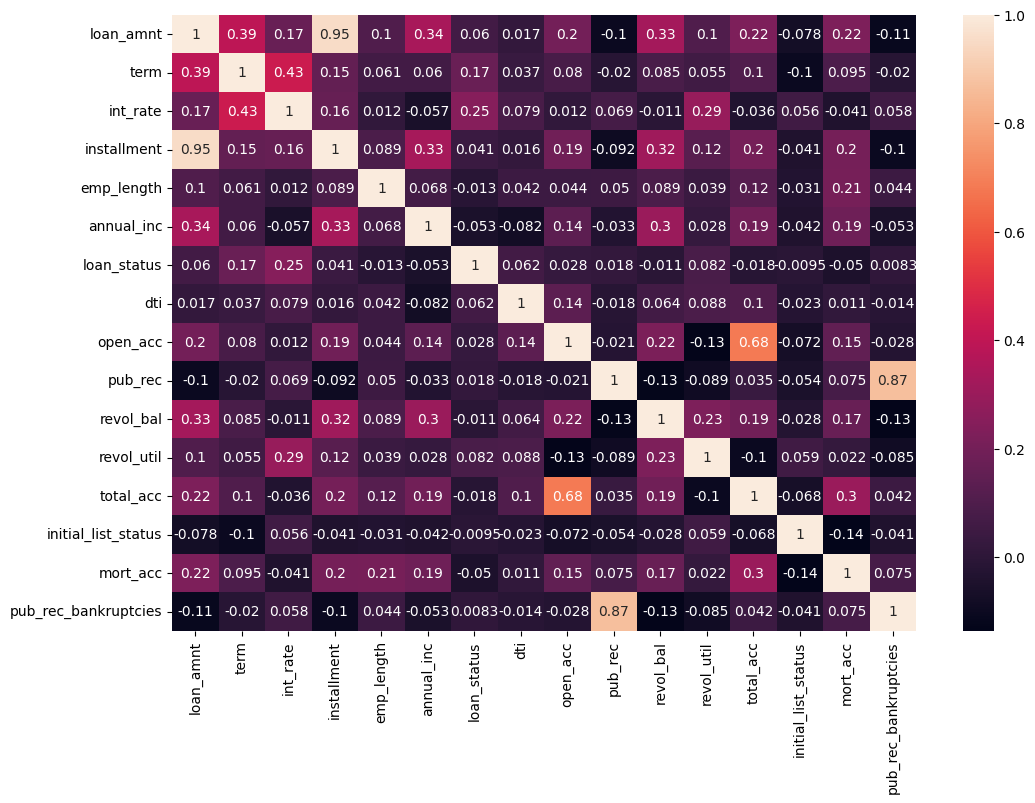

In [130]:
plt.figure(figsize=(12, 8))

sns.heatmap(df.corr(numeric_only=True), annot=True)

2. Comment about the correlation between Loan Amount and Installment features.


- There is a correlation between **open_acc** and **total_acc**
- There is a correlation between **pub_rec_bankruptcies** and **puc_rec**
- There is a strong correlation between **loan_amount** and **installment**
- Initial analysis shows 3 of these columns could be dropped

## Outlier Detection

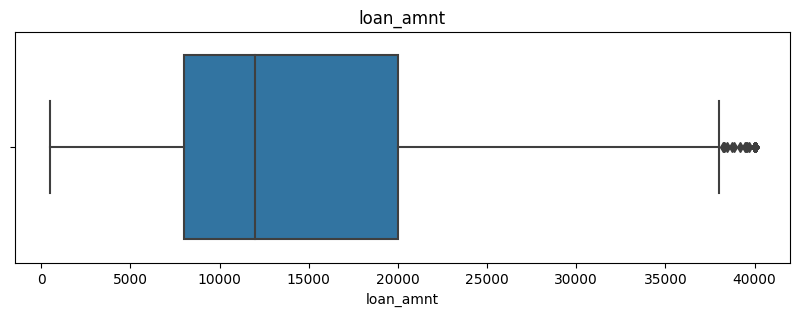

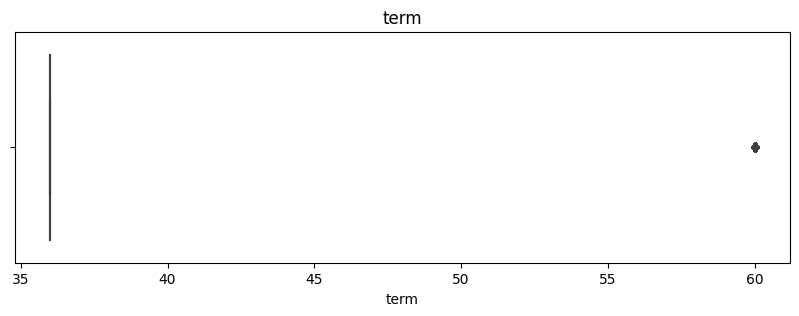

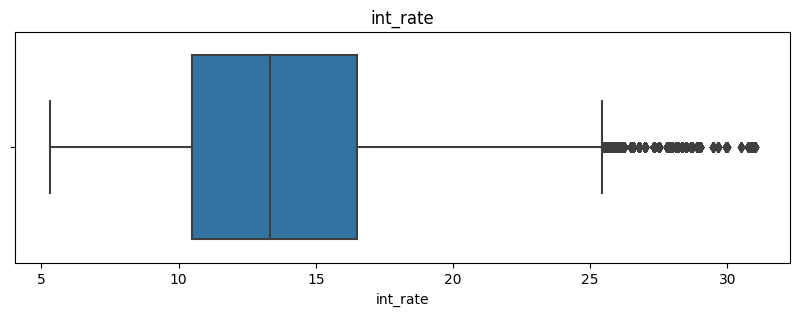

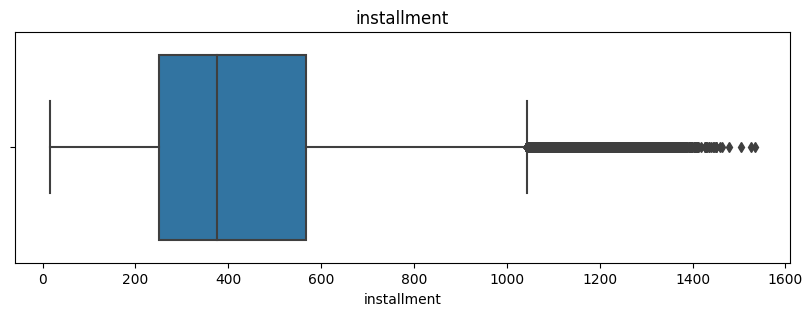

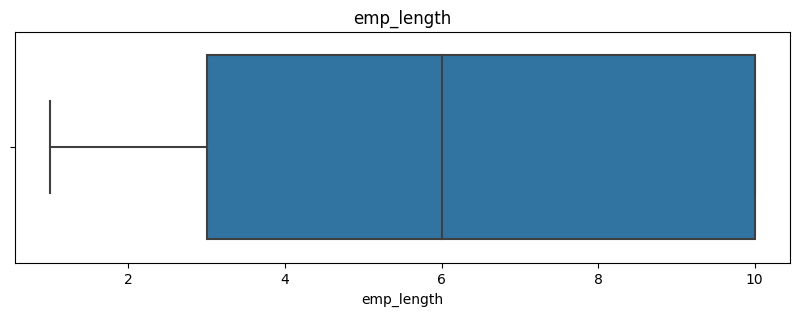

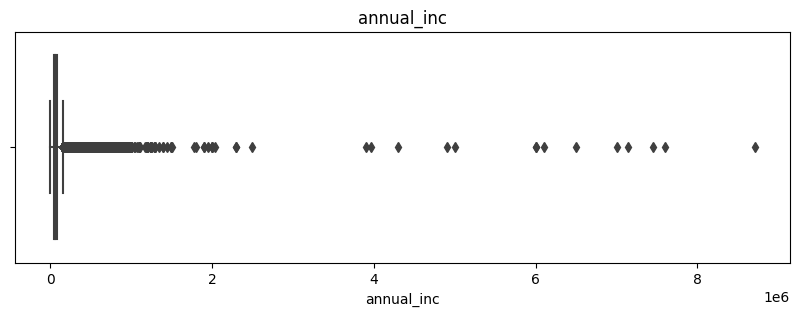

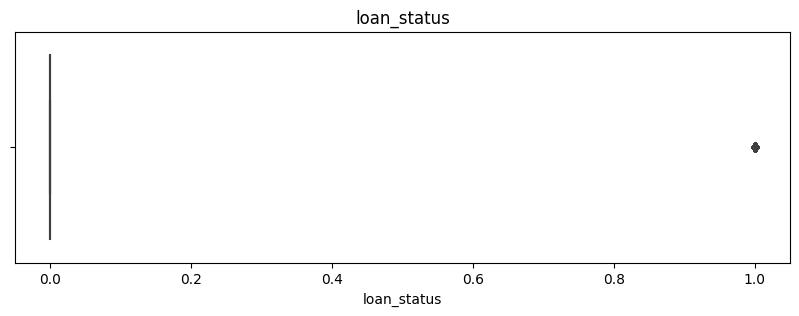

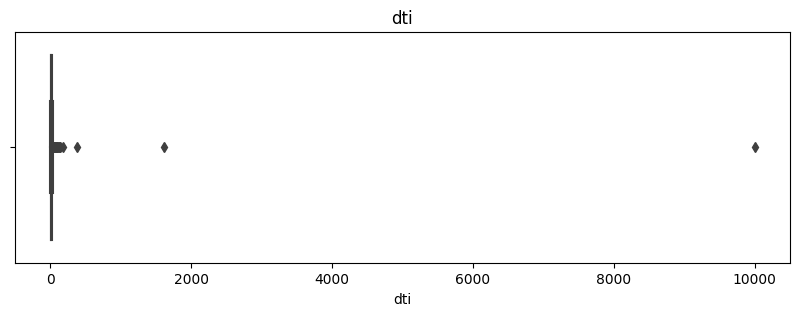

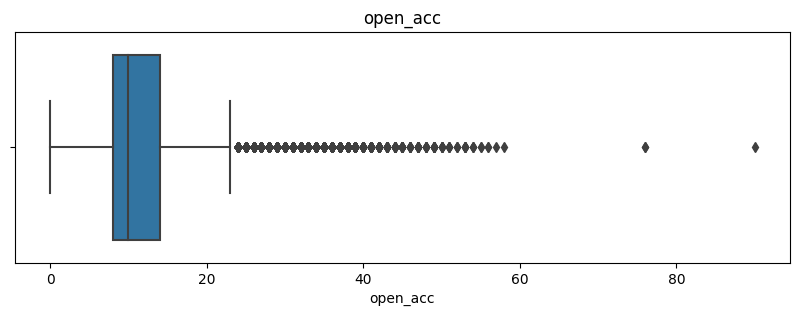

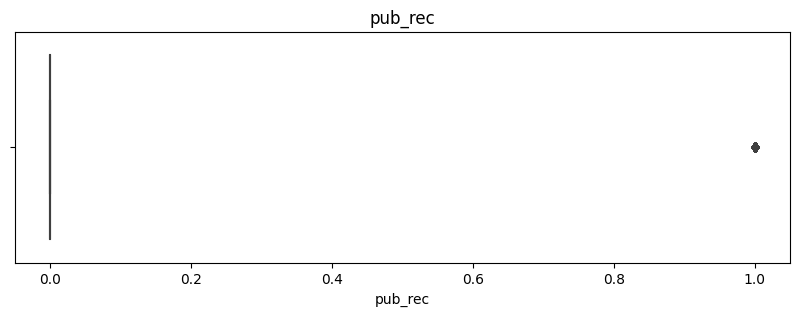

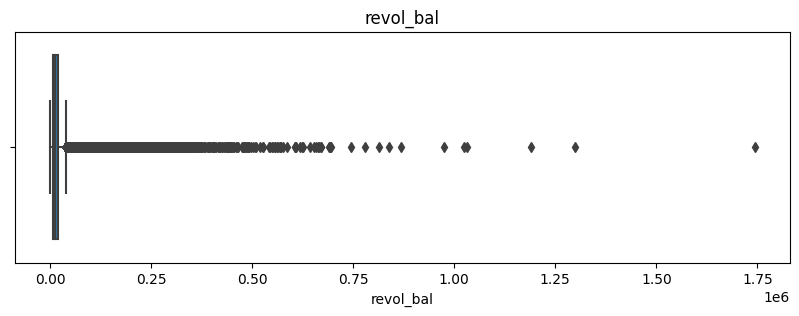

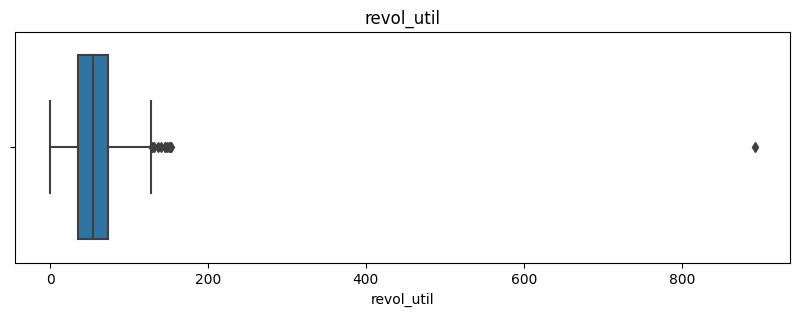

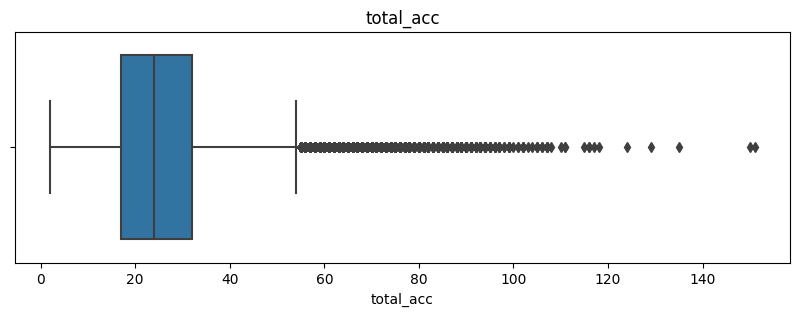

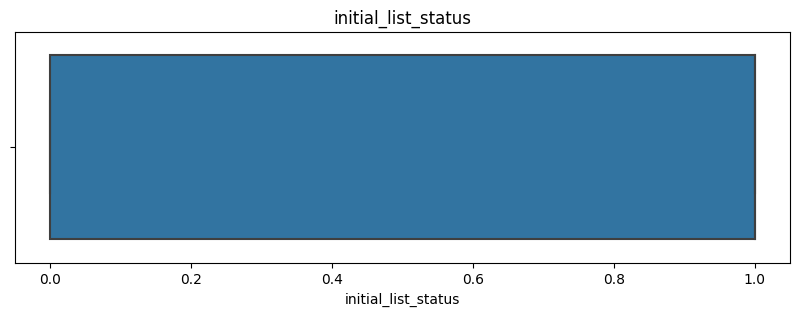

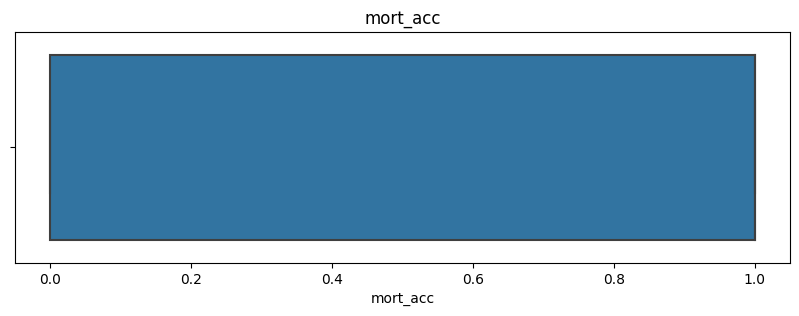

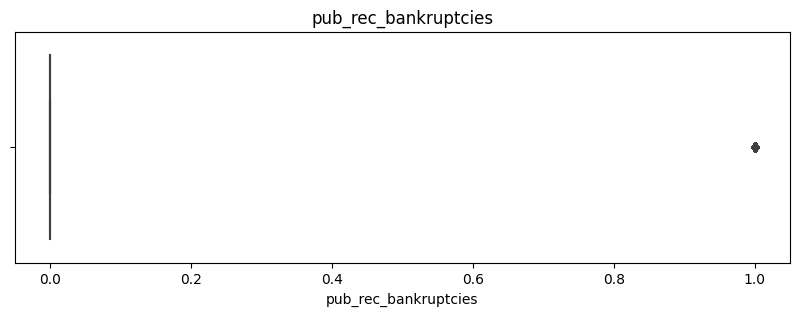

In [131]:
numerica_columns = df.select_dtypes(include=['number']).columns
for col in numerica_columns:
    plt.figure(figsize=(10,3))
    sns.boxplot(data=df, x=col, hue='loan_status')
    plt.title(col)
    if col in ('purpose'):
        plt.xticks(rotation='vertical')
    plt.show()

In [23]:
df.shape

(396030, 27)

### Questionnaire

1. What percentage of customers have fully paid their Loan Amount?


In [218]:
df['loan_status'].value_counts(normalize=True)*100

0    80.387092
1    19.612908
Name: loan_status, dtype: float64

- Imbalanced dataset. 80% of the data is referring to fully paid and 19% is referring to charged off (NPA)

3.The majority of people have home ownership as _______.


In [7]:
df['home_ownership'].value_counts()

MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          112
NONE            31
ANY              3
Name: home_ownership, dtype: int64

2. The majority of ownership as Mortgage and Rent

In [132]:
data = df

[Text(0, 0, 'A1'),
 Text(1, 0, 'A2'),
 Text(2, 0, 'A3'),
 Text(3, 0, 'A4'),
 Text(4, 0, 'A5'),
 Text(5, 0, 'B1'),
 Text(6, 0, 'B2'),
 Text(7, 0, 'B3'),
 Text(8, 0, 'B4'),
 Text(9, 0, 'B5'),
 Text(10, 0, 'C1'),
 Text(11, 0, 'C2'),
 Text(12, 0, 'C3'),
 Text(13, 0, 'C4'),
 Text(14, 0, 'C5'),
 Text(15, 0, 'D1'),
 Text(16, 0, 'D2'),
 Text(17, 0, 'D3'),
 Text(18, 0, 'D4'),
 Text(19, 0, 'D5'),
 Text(20, 0, 'E1'),
 Text(21, 0, 'E2'),
 Text(22, 0, 'E3'),
 Text(23, 0, 'E4'),
 Text(24, 0, 'E5'),
 Text(25, 0, 'F1'),
 Text(26, 0, 'F2'),
 Text(27, 0, 'F3'),
 Text(28, 0, 'F4'),
 Text(29, 0, 'F5'),
 Text(30, 0, 'G1'),
 Text(31, 0, 'G2'),
 Text(32, 0, 'G3'),
 Text(33, 0, 'G4'),
 Text(34, 0, 'G5')]

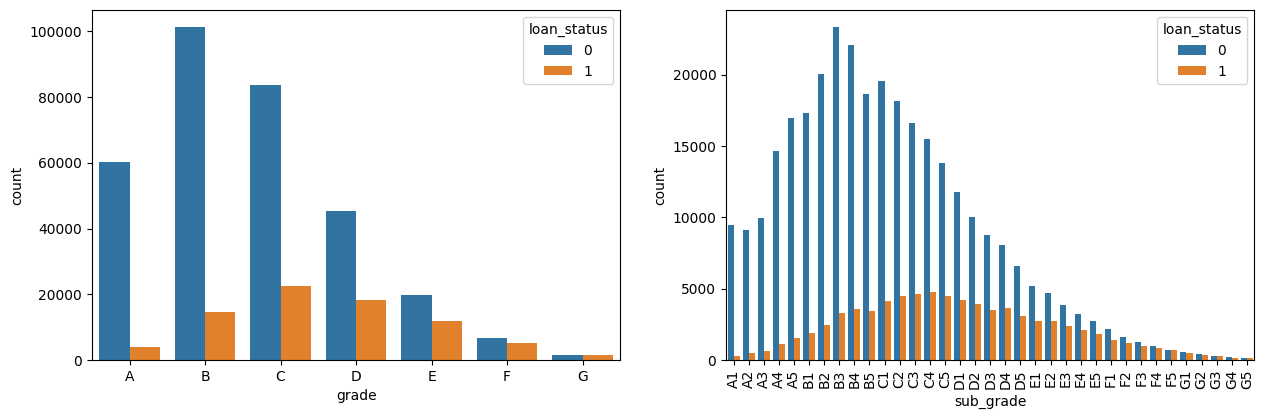

In [133]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
grade = sorted(data.grade.unique().tolist())
sns.countplot(x='grade', data=data, hue='loan_status', order=grade)

plt.subplot(2, 2, 2)
sub_grade = sorted(data.sub_grade.unique().tolist())
g = sns.countplot(x='sub_grade', data=data, hue='loan_status', order=sub_grade)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

4. People with grades ‘A’ are more likely to fully pay their loan. (T/F) - True

- customers of grade B has paid off the loans max.
- Customers of sub-grade B3 are ranking top among the loans paid off.
- Highest defaulters are in grade C and C4 sub-grade
- Looks like grade and sub-grade are highly correlated.

[Text(0, 0, 'vacation'),
 Text(1, 0, 'debt_consolidation'),
 Text(2, 0, 'credit_card'),
 Text(3, 0, 'home_improvement'),
 Text(4, 0, 'small_business'),
 Text(5, 0, 'major_purchase'),
 Text(6, 0, 'other'),
 Text(7, 0, 'medical'),
 Text(8, 0, 'wedding'),
 Text(9, 0, 'car'),
 Text(10, 0, 'moving'),
 Text(11, 0, 'house'),
 Text(12, 0, 'educational'),
 Text(13, 0, 'renewable_energy')]

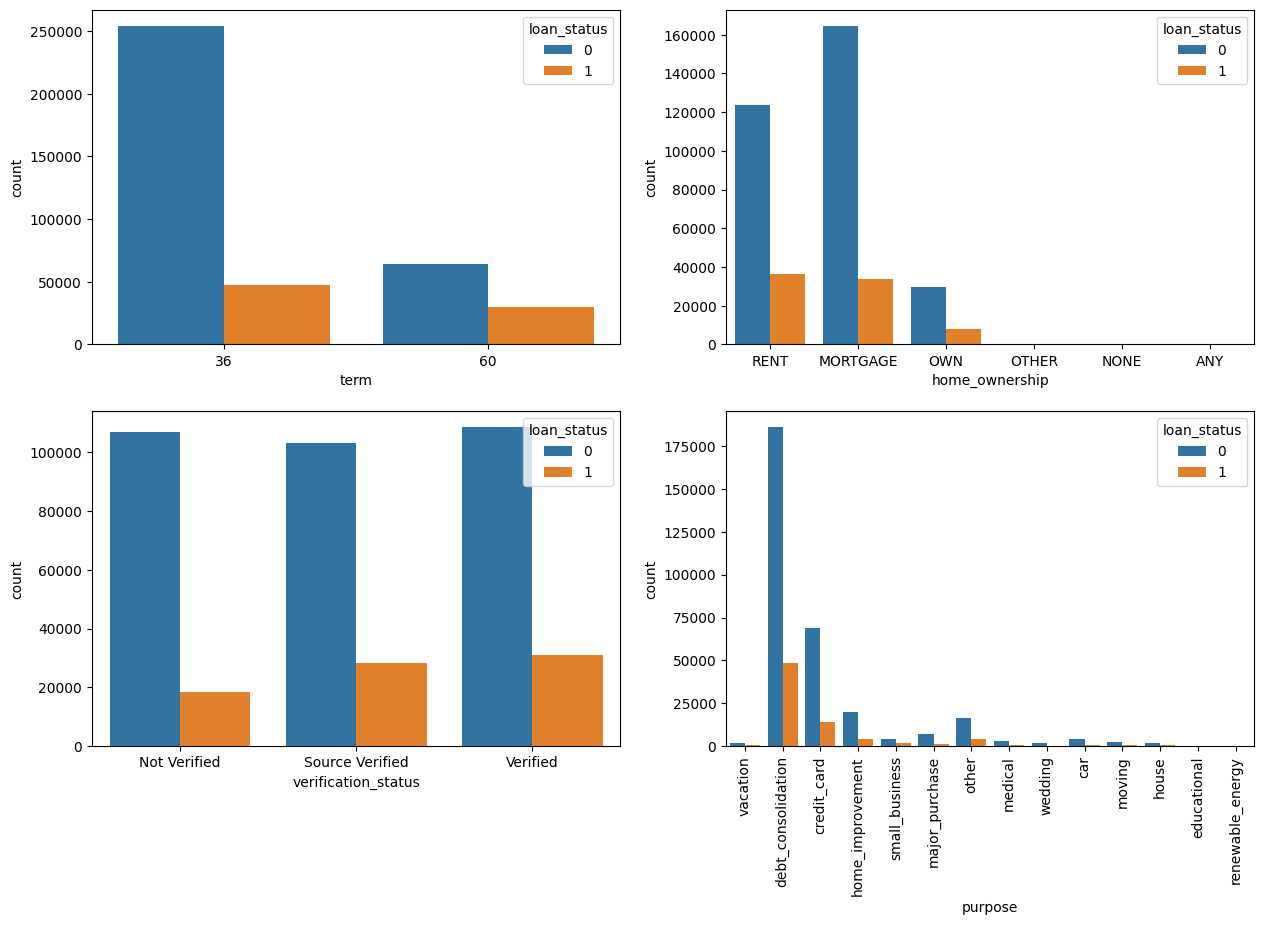

In [134]:
plt.figure(figsize=(15,20))

plt.subplot(4,2,1)
sns.countplot(x='term',data=data,hue='loan_status')

plt.subplot(4,2,2)
sns.countplot(x='home_ownership',data=data,hue='loan_status')

plt.subplot(4,2,3)
sns.countplot(x='verification_status',data=data,hue='loan_status')

plt.subplot(4,2,4)
g=sns.countplot(x='purpose',data=data,hue='loan_status')
g.set_xticklabels(g.get_xticklabels(),rotation=90)

5.Name the top 2 afforded job titles.

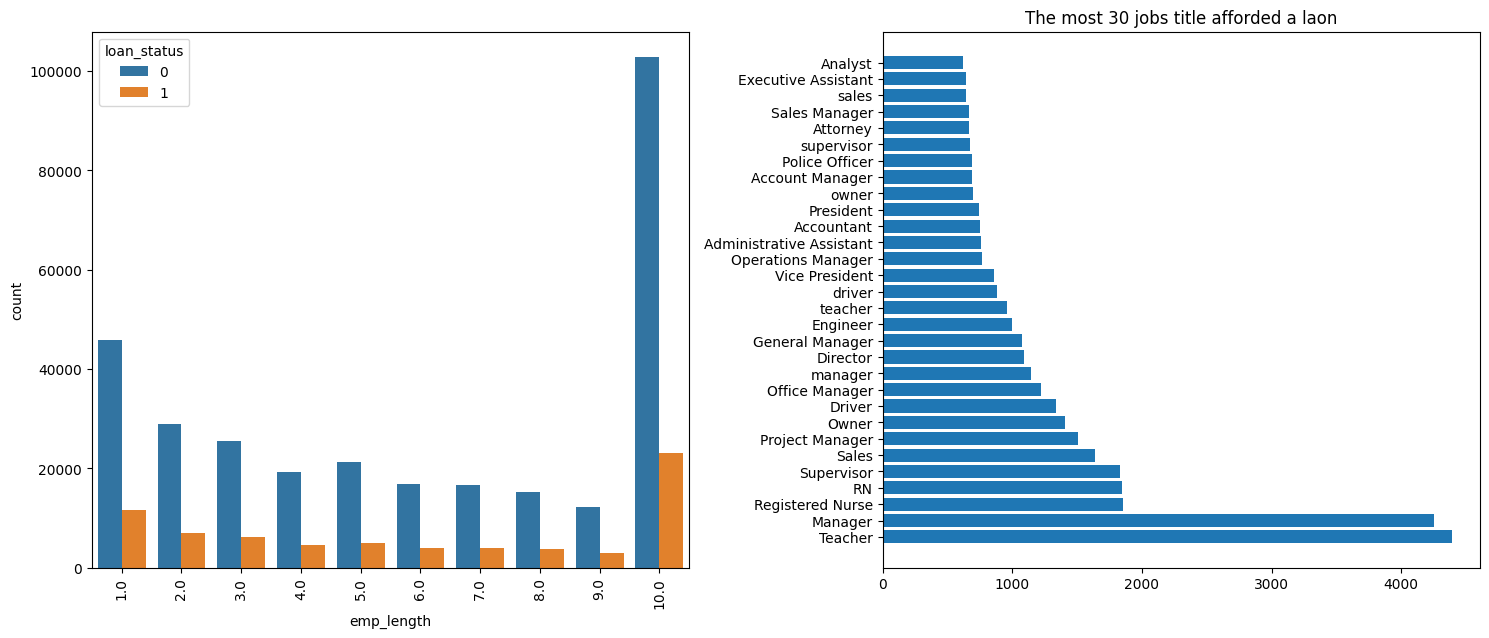

In [135]:
plt.figure(figsize=(15,12))

plt.subplot(2,2,1)

g=sns.countplot(x='emp_length',data=data,hue='loan_status')
g.set_xticklabels(g.get_xticklabels(),rotation=90)

plt.subplot(2,2,2)
plt.barh(data.emp_title.value_counts()[:30].index,data.emp_title.value_counts()[:30])
plt.title("The most 30 jobs title afforded a laon")
plt.tight_layout()

- Manager and Teacher are the most afforded loan on titles

In [175]:
df.drop(['sub_grade', 'title', 'address', 'earliest_cr_line','issue_d'],axis=1, inplace=True)

In [176]:
df.drop('emp_title', axis=1, inplace=True)

In [177]:
df.select_dtypes('object').columns

Index(['grade', 'home_ownership', 'verification_status', 'purpose',
       'application_type', 'zip_code'],
      dtype='object')

In [178]:
df = pd.get_dummies(df, columns=['grade', 'home_ownership', 'verification_status', 'application_type','purpose',
       'zip_code'])

In [179]:
df.shape

(396030, 59)

### Logistic Regression Modelling

In [180]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']
X_train, X_test , y_train, y_test = train_test_split(X,y, stratify=y, train_size=0.80, random_state=42)

In [181]:
X_train.shape, y_train.shape, X_test.shape

((316824, 58), (316824,), (79206, 58))

In [182]:
X_train.isna().sum()

loan_amnt                                  0
term                                       0
int_rate                                   0
installment                                0
emp_length                             14661
annual_inc                                 0
dti                                        0
open_acc                                   0
pub_rec                                    0
revol_bal                                  0
revol_util                               216
total_acc                                  0
initial_list_status                        0
mort_acc                                   0
pub_rec_bankruptcies                       0
grade_A                                    0
grade_B                                    0
grade_C                                    0
grade_D                                    0
grade_E                                    0
grade_F                                    0
grade_G                                    0
home_owner

In [183]:
train_imputes = {k:X_train[k].mode()[0] for k in ('emp_length', 'revol_util') }
    

In [184]:
train_imputes

{'emp_length': 10.0, 'revol_util': 0.0}

In [185]:
for i,v in train_imputes.items():
    X_train[i] = np.where(X_train[i].isna(),train_imputes[i],X_train[i])

## Outlier Detection

In [186]:
IQR = X_train.quantile(0.75, numeric_only=True) - X_train.quantile(0.25, numeric_only=True)
train_upper_bound = X_train.quantile(0.75, numeric_only=True) + 1.5*IQR

- Calculating upper IQR limit of training set. This will be used to clip the outliers.

In [187]:
train_upper_bound

loan_amnt                               38000.00
term                                       36.00
int_rate                                   25.49
installment                              1043.23
emp_length                                 20.50
annual_inc                             157500.00
dti                                        40.53
open_acc                                   23.00
pub_rec                                     0.00
revol_bal                               40042.00
revol_util                                128.55
total_acc                                  54.50
initial_list_status                         2.50
mort_acc                                    2.50
pub_rec_bankruptcies                        0.00
grade_A                                     0.00
grade_B                                     2.50
grade_C                                     2.50
grade_D                                     0.00
grade_E                                     0.00
grade_F             

In [2100]:
# for col in train_upper_bound.index:
#     X_train[col] = np.where(X_train[col]>=train_upper_bound[col],train_upper_bound[col], X_train[col])

- Scaling and normalization on train data

In [188]:
# scaler = StandardScaler()
minmaxscaler = MinMaxScaler()
X_train[X_train.columns]= minmaxscaler.fit_transform(X_train)

Applying same transformations on test data

In [16]:
# for col in train_upper_bound.index:
#     X_test[col] = np.where(X_test[col]>=train_upper_bound[col],train_upper_bound[col], X_test[col])

In [189]:
for i,v in train_imputes.items():
    X_test[i] = np.where(X_test[i].isna(),train_imputes[i],X_test[i])

In [190]:
X_test[X_test.columns]= minmaxscaler.fit_transform(X_test, y_test)

In [191]:
X_test.head()

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,mort_acc,pub_rec_bankruptcies,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,application_type_DIRECT_PAY,application_type_INDIVIDUAL,application_type_JOINT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,zip_code_00813,zip_code_05113,zip_code_11650,zip_code_22690,zip_code_29597,zip_code_30723,zip_code_48052,zip_code_70466,zip_code_86630,zip_code_93700
111897,0.086538,0.0,0.018309,0.072640,0.000000,0.003142,0.018163,0.055556,0.0,0.007042,0.308852,0.087248,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
273798,0.025641,0.0,0.427347,0.031551,1.000000,0.003079,0.007491,0.077778,0.0,0.006441,0.558689,0.174497,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34045,0.307692,0.0,0.312037,0.276106,1.000000,0.010506,0.023502,0.144444,0.0,0.006562,0.142951,0.181208,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
83809,0.615385,0.0,0.100117,0.502499,1.000000,0.009790,0.010080,0.322222,0.0,0.046374,0.139016,0.315436,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
279718,0.230769,0.0,0.503701,0.224930,0.333333,0.005448,0.004778,0.088889,0.0,0.010701,0.611148,0.053691,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [158]:
len(X_train), len(y_train),  len(X_test),len(y_test)

(316824, 316824, 79206, 79206)

In [159]:
def confusion_classification(y_test, y_pred):
    print('*' * 50)
    print('CONFUSION MATRIX')
    print('*' * 50)
    print(confusion_matrix(y_test, y_pred, labels=[0,1]))
    print("\n")
    print('*' * 50)
    print('CLASSIFICATION MATRIX')
    print('*' * 50)
    print(classification_report(y_pred, y_test,target_names=['Paid Fully','Charged Off']))

In [192]:
logreg = LogisticRegression(random_state=40, max_iter=1000)
model = logreg.fit(X_train, y_train)
y_pred = model.predict(X_test[X_train.columns])

In [193]:
confusion_classification(y_test, y_pred)

**************************************************
CONFUSION MATRIX
**************************************************
[[55383  8288]
 [ 4714 10821]]


**************************************************
CLASSIFICATION MATRIX
**************************************************
              precision    recall  f1-score   support

  Paid Fully       0.87      0.92      0.89     60097
 Charged Off       0.70      0.57      0.62     19109

    accuracy                           0.84     79206
   macro avg       0.78      0.74      0.76     79206
weighted avg       0.83      0.84      0.83     79206



- False positives [people who have paid off loans but are identified as defaulters] are high in this model

In [194]:
def draw_precision_recall_curves(y_test,y_pred_proba, title ):
    p,r , thresholds = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(p[0:thresholds.shape[0]],thresholds, label='precision')
    plt.plot(r[0:thresholds.shape[0]],thresholds, label='recall')
    start,end=plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    plt.xlabel('Threshold')
    plt.ylabel('Precision/Recall')
    plt.title(f'Precision-Recall trade off- {title}')
    plt.legend()
    plt.grid()

In [195]:
def draw_roc_curve(md, X_test,y_test,y_pred, title):
    plt.figure()
    tpr, fpr, thresholds = roc_curve(y_test, md.predict_proba(X_test)[:,1])
    plt.plot(fpr,tpr,label='Logistic Regression (area = %0.2f)' % roc_auc_score(y_test, y_pred))
    plt.plot([0,1],[0,1],'y--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver operating characteristic - {title}')
    plt.legend(loc="lower right")
    plt.show()

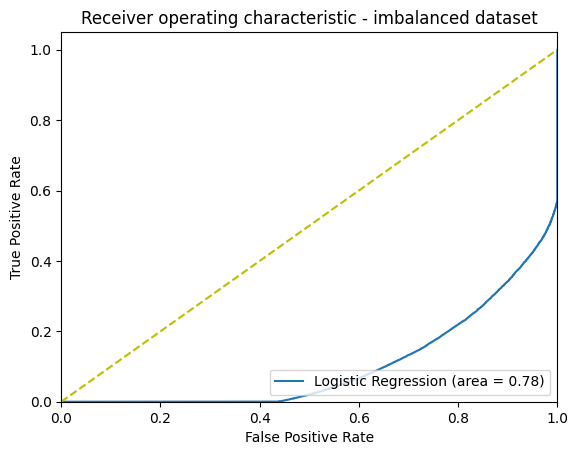

In [196]:
draw_roc_curve(model, X_test, y_test,y_pred, 'imbalanced dataset')

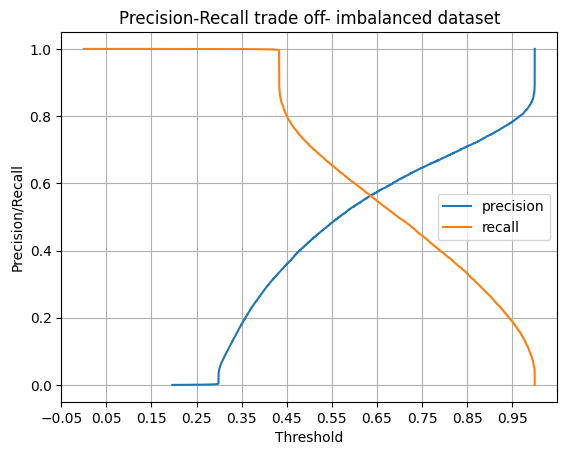

In [197]:
draw_precision_recall_curves(y_test,model.predict_proba(X_test)[:,1], 'imbalanced dataset')

## Handling imbalanced dataset using class weights

In [198]:
logreg = LogisticRegression(class_weight='balanced', random_state=40, max_iter=1000)
model = logreg.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [200]:
confusion_classification(y_test, y_pred)

**************************************************
CONFUSION MATRIX
**************************************************
[[36568 27103]
 [  769 14766]]


**************************************************
CLASSIFICATION MATRIX
**************************************************
              precision    recall  f1-score   support

  Paid Fully       0.57      0.98      0.72     37337
 Charged Off       0.95      0.35      0.51     41869

    accuracy                           0.65     79206
   macro avg       0.76      0.67      0.62     79206
weighted avg       0.77      0.65      0.61     79206



- After applying class weights, precision has increased for Charged Off class
- accuracy has reduced.
- As expected, macro and weighted avg are the same after balacing the classes

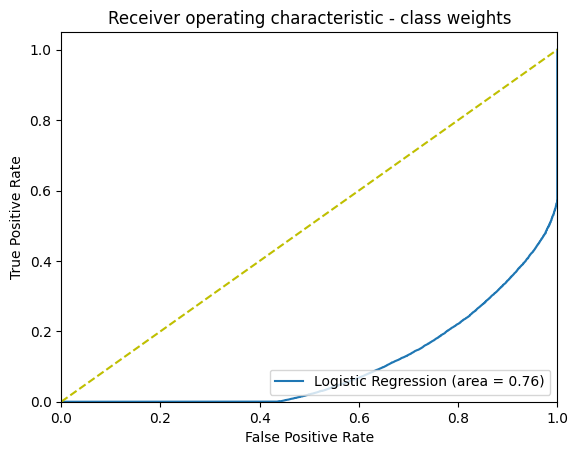

In [201]:
draw_roc_curve(model, X_test, y_test,y_pred, 'class weights')

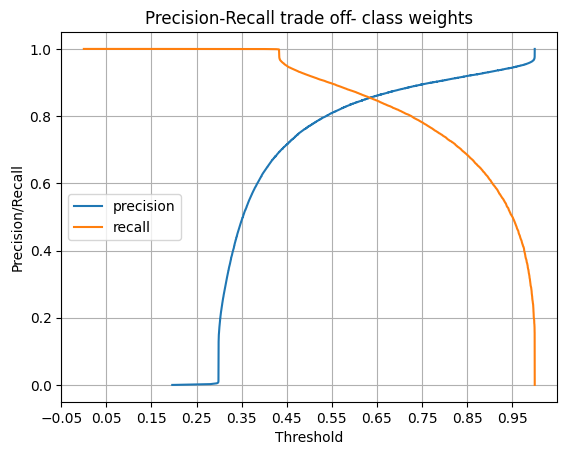

In [202]:
draw_precision_recall_curves(y_test,model.predict_proba(X_test)[:,1], 'class weights')

## Handling imbalanced data using SMOTE

In [203]:
sm = SMOTE(random_state=4)
X_train_re, y_train_re = sm.fit_resample(X_train, y_train)

<Axes: xlabel='loan_status', ylabel='Count'>

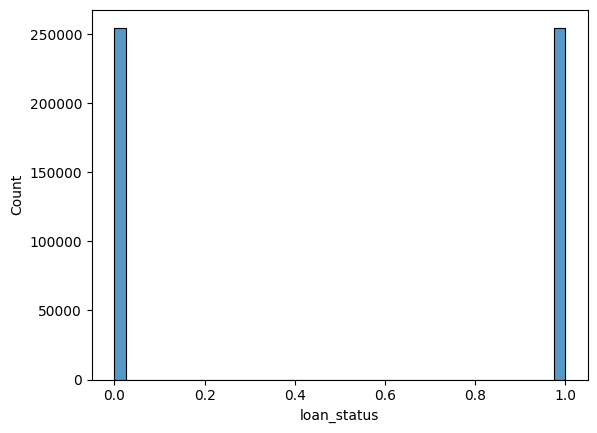

In [204]:
sns.histplot(y_train_re)

In [205]:
model_re = logreg.fit(X_train_re, y_train_re)
y_pred = model_re.predict(X_test)

In [206]:
confusion_classification(y_test, y_pred)

**************************************************
CONFUSION MATRIX
**************************************************
[[35508 28163]
 [  666 14869]]


**************************************************
CLASSIFICATION MATRIX
**************************************************
              precision    recall  f1-score   support

  Paid Fully       0.56      0.98      0.71     36174
 Charged Off       0.96      0.35      0.51     43032

    accuracy                           0.64     79206
   macro avg       0.76      0.66      0.61     79206
weighted avg       0.77      0.64      0.60     79206



- The score numbers are matching when trying with class weights and SMOTE technique

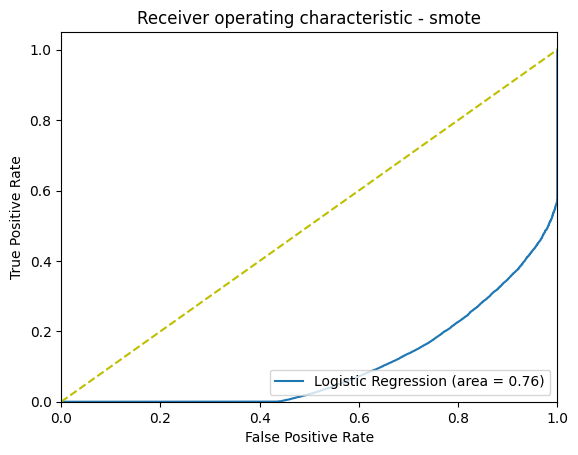

In [207]:
draw_roc_curve(model_re, X_test, y_test,y_pred, 'smote')

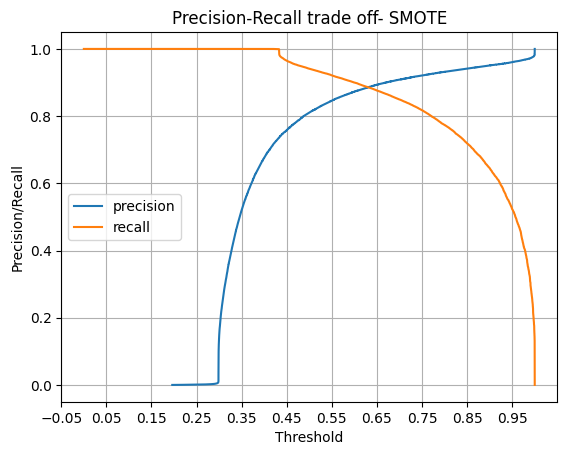

In [208]:
draw_precision_recall_curves(y_test,model_re.predict_proba(X_test)[:,1], 'SMOTE')

## Multi-Collineality Check

In [105]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

df_n = X_train.iloc[:,:-1]
while True:
    _df = pd.DataFrame()
    _df['feature'] = df_n.columns
    _df['VIF'] = [variance_inflation_factor(df_n,i) for i,v in enumerate(df_n.columns)]
    print("\n")
    
    _df = _df.sort_values(by=['VIF'],ascending=False)
    _df = _df[_df['VIF']>5]
    print(_df)
    
    _col = _df.iloc[0]['feature'] if len(_df)>0 else None
    
    if _col:
        print("\n")
        print(f"dropping {_col} and re-calculating vif")
        df_n = df_n.drop(_col, axis=1)
    else:
        break



                        feature         VIF
0                     loan_amnt  218.381768
3                   installment  195.885030
45  application_type_INDIVIDUAL  101.102495
2                      int_rate   55.643553
16   purpose_debt_consolidation   49.112264
15          purpose_credit_card   18.052509
7                      open_acc   11.760586
39                      grade_D   11.475406
11                    total_acc   10.174975
38                      grade_C   10.156943
40                      grade_E    9.259867
1                          term    8.941917
10                   revol_util    7.837921
18     purpose_home_improvement    5.902813
41                      grade_F    5.788762
23                purpose_other    5.341720
37                      grade_B    5.328771


dropping loan_amnt and re-calculating vif


                        feature         VIF
44  application_type_INDIVIDUAL  100.836174
1                      int_rate   52.544303
15   purpose_debt_consolidat

In [107]:
imp_cols = df_n.columns

In [108]:
imp_cols

Index(['term', 'emp_length', 'annual_inc', 'dti', 'pub_rec', 'revol_bal',
       'initial_list_status', 'mort_acc', 'pub_rec_bankruptcies',
       'purpose_credit_card', 'purpose_educational',
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_other',
       'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'zip_code_05113',
       'zip_code_11650', 'zip_code_22690', 'zip_code_29597', 'zip_code_30723',
       'zip_code_48052', 'zip_code_70466', 'zip_code_86630', 'zip_code_93700',
       'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G',
       'verification_status_Source Verified', 'verification_status_Verified',
       'application_type_JOINT', 'home_ownership_MORTGAGE',
       'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN'],
      dtype='object')

- Above columns should be considered for modelling

## Hyper parameter tuning

In [146]:
from sklearn.model_selection import GridSearchCV
param_grid = {
'penalty' :['l1', 'l2','elasticnet', None],
 'C': [0.1,0.01,0.001,0.0001],
 'max_iter': [50,100,1000]
}
gsv = GridSearchCV(estimator=LogisticRegression(class_weight='balanced'), param_grid=param_grid,cv=5, return_train_score=True, scoring = 'precision')
gsv_model = gsv.fit(X_train_re[imp_cols], y_train_re)


/Users/ajmal.m/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ajmal.m/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

/Users/ajmal.m/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ajmal.m/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ajmal.m/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ajmal.m/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logis

/Users/ajmal.m/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ajmal.m/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ajmal.m/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
 

/Users/ajmal.m/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ajmal.m/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ajmal.m/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ajmal.m/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logis

/Users/ajmal.m/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ajmal.m/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ajmal.m/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ajmal.m/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logis

In [147]:
gsv.best_score_

0.8675004453939209

In [148]:
gsv.best_params_

{'C': 0.0001, 'max_iter': 50, 'penalty': 'l2'}

In [209]:
logreg = LogisticRegression(C=0.001,max_iter=50, penalty= 'l2', class_weight='balanced')
md2 = logreg.fit(X_train[imp_cols], y_train)
y_pred = md2.predict(X_test[imp_cols])


In [210]:
md2.score(X_test[imp_cols], y_test)

0.7990177511804661

In [211]:
confusion_classification(y_test, y_pred)

**************************************************
CONFUSION MATRIX
**************************************************
[[51258 12413]
 [ 3506 12029]]


**************************************************
CLASSIFICATION MATRIX
**************************************************
              precision    recall  f1-score   support

  Paid Fully       0.81      0.94      0.87     54764
 Charged Off       0.77      0.49      0.60     24442

    accuracy                           0.80     79206
   macro avg       0.79      0.71      0.73     79206
weighted avg       0.80      0.80      0.78     79206



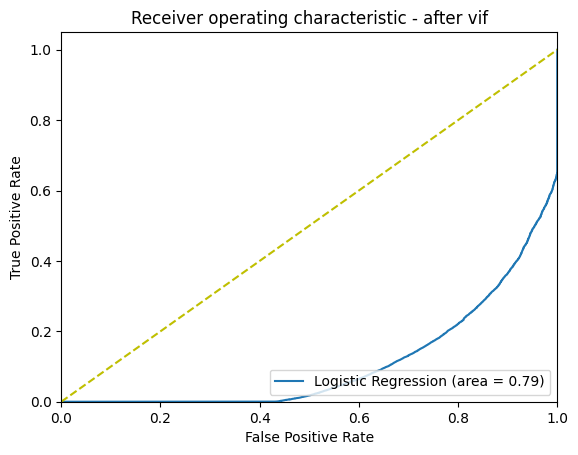

In [212]:
draw_roc_curve(md2, X_test[imp_cols],y_test, y_pred, title='after vif' )

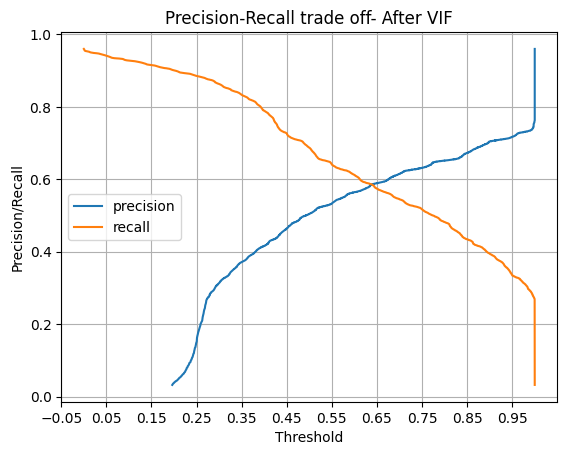

In [213]:
draw_precision_recall_curves(y_test,md2.predict_proba(X_test[imp_cols])[:,1], 'After VIF')


## ROC Curve

- ROC curve shows the relation between True Positive Rate and False Positive Rate for different values of thresholds
- In the context of **LoanTap**, positive refers to identifying a defaulter and negative refers to people who have paid off the loans
- TPR or recall is TP/TP+FN - The rate of identfying true positives among the actual positives.
- fpr = fp/(fp+tn) - The rate of false positives among actual negatives
- TPR - ability to identify defaulters among all the possible defaulters. The value should generally be high
- FPR - This metric concetrates on the rate of incorrectly labelling a good candidate among the pool of good candidates.
- For Loantap, FPR shouldn't be the major focus here

## Precision-Recall Curve
- Plots the values of precision and recall for different values of thresholds.
- precision = TP/(TP + FP) - Ability to identify defaulters among the predicted pool of defaulters
- TPR or recall is TP/TP+FN - The rate of identfying true positives among the actual positives.
- Precision should be main focus for LoanTap


In [255]:
imp_cols[np.argsort(md2.coef_[0])[::-1][:5]]

Index(['zip_code_11650', 'zip_code_93700', 'zip_code_86630', 'grade_E',
       'grade_F'],
      dtype='object')

In [256]:
imp_cols

Index(['term', 'emp_length', 'annual_inc', 'dti', 'pub_rec', 'revol_bal',
       'initial_list_status', 'mort_acc', 'pub_rec_bankruptcies',
       'purpose_credit_card', 'purpose_educational',
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_other',
       'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'zip_code_05113',
       'zip_code_11650', 'zip_code_22690', 'zip_code_29597', 'zip_code_30723',
       'zip_code_48052', 'zip_code_70466', 'zip_code_86630', 'zip_code_93700',
       'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G',
       'verification_status_Source Verified', 'verification_status_Verified',
       'application_type_JOINT', 'home_ownership_MORTGAGE',
       'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN'],
      dtype='object')

In [263]:
np.array(imp_cols)[md2.coef_[0]<0]

array(['annual_inc', 'revol_bal', 'initial_list_status', 'mort_acc',
       'pub_rec_bankruptcies', 'purpose_credit_card',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_other', 'purpose_vacation',
       'purpose_wedding', 'zip_code_05113', 'zip_code_29597',
       'application_type_JOINT', 'home_ownership_MORTGAGE',
       'home_ownership_OTHER', 'home_ownership_OWN'], dtype=object)

In [264]:
np.array(imp_cols)[md2.coef_[0]>0]

array(['term', 'emp_length', 'dti', 'pub_rec', 'purpose_medical',
       'purpose_moving', 'purpose_renewable_energy',
       'purpose_small_business', 'zip_code_11650', 'zip_code_22690',
       'zip_code_30723', 'zip_code_48052', 'zip_code_70466',
       'zip_code_86630', 'zip_code_93700', 'grade_B', 'grade_C',
       'grade_D', 'grade_E', 'grade_F', 'grade_G',
       'verification_status_Source Verified',
       'verification_status_Verified', 'home_ownership_NONE'],
      dtype=object)

## Insights

- Customers seeking loans for  educational, credit card, home improvement, wedding etc. tend to repay the loan fully. LoanPay should look into sanctioning loans to this category
- Customers seeking loan for small business, renewable energy have a negative correlation. 
- Customers should be encouraged for JOINT application type. Improve ads and marketing around this type. 
- Customers belonging to pin codes 05113 and 29597 are showing more tendency to paying the loans in full. Increase ads and good interest rate to gain the market in this area